### Visualizing the distribution of the observations

### Load the required libraries

In [397]:
sc.stop()

In [422]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print STAT_Descriptions
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
[('SortedVals', 'Sample of values', 'vector whose length varies between measurements'), ('UnDef', 'sample of number of undefs per row', 'vector whose length varies between measurements'), ('mean', 'mean value', ()), ('std', 'std', ()), ('low100', 'bottom 1%', ()), ('high100', 'top 1%', ()), ('low1000', 'bottom 0.1%', ()), ('high1000', 'top 0.1%', ()), ('E', 'Sum of values per day', (365,)), ('NE', 'count of values per day', (365,)), ('Mean', 'E/NE', (365,)), ('O', 'Sum of outer products', (365, 365)), ('NO', 'counts for outer products', (365, 365)), ('Cov', 'O/NO', (365, 365)), ('Var', 'The variance per day = diagonal of Cov', (365,)), ('eigval', 'PCA eigen-values', (365,)), ('eigvec', 'PCA eigen-vectors', (365, 365))]
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12376
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurem

- import all modules
- create a spak context and then a sqlcontext using that as we need to manipulate and study data
- load data from pickle file created for the region assigned i.e 'SBSSBBBS'
- data includes the statistics like sorted values, top 1%, bottom 1%, mean, standard deviation, eigen values, variance, number of values per day etc.
- All the values are for measurements: 'TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'
- Measurements:
  PRCP = Precipitation (tenths of mm)  
  SNOW = Snowfall (mm)  
  SNWD = Snow depth (mm)  
  TMAX = Maximum temperature (tenths of degrees C)  
  TMIN = Minimum temperature (tenths of degrees C)  
  TOBS = Temperature at the time of observation (tenths of degrees C)  
- Data of station-year pairs with information like elevation, lat,long, measurement, what is vector, undefs??


### Select data for a particular station and measurement type

In [423]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00105980')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print len(rows)
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00105980'
61 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       PRCP|USC00105980|     0|[40 4E 00 45 00 0...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       PRCP|USC00105980|     0|[00 00 00 49 00 0...|1950.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

61


(61, 365)

In [424]:
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00105980')
print Query
df1 = sqlContext.sql(Query)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00105980'


- check data for a particular statioon
- changing temperature from 10th of degree to in centigrades using unpack and v-stack for getting vertical arrays in T

In [425]:
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00105980')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TM=np.vstack(rows)
TM=TM/10.  # scaling to make the temperature be in centingrates
shape(TM)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00105980'
62 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|    10|[80 49 40 4C E0 D...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     1|[30 54 40 4C A0 D...|1950.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(62, 365)

In [426]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\twhere measurement='%s' sort by year desc"%('SNWD')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print len(rows)
T_S=np.vstack(rows)  # scaling to make the temperature be in centingrates
shape(T_S)

SELECT * FROM weather
	where measurement='SNWD' sort by year desc
1125 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1619.1| 43.5186|-114.3025|       SNWD|USC00103940|    27|[40 4E 40 4E 40 4...|2012.0|SBSSBBBS|
|   1382.6| 43.1969|-112.3531|       SNWD|USC00100915|    37|[00 00 00 00 00 0...|2012.0|SBSSBBBS|
|   1472.2| 43.3111|-114.0742|       SNWD|USC00107040|    26|[00 00 00 00 00 0...|2012.0|SBSSBBBS|
|   1158.2| 42.6006|-114.7453|       SNWD|USC00101220|    19|[00 00 00 00 00 0...|2012.0|SBSSBBBS|
|   1342.6| 42.9536|-112.8253|       SNWD|USC00100010|    30|[00 00 00 00 00 0...|2012.0|SBSSBBBS|
|   1360.9| 43.0428|-112.4133|       SNWD|USC00103297|    31|[00 00 00 00 00 0...|2012.0|SBSSBBBS|
|   1795.3| 43.6842|-114.3603|   

(1125, 365)

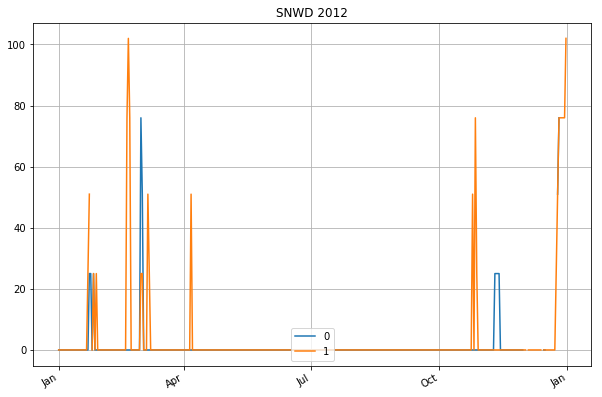

In [427]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T_S[8:10,:].transpose(),fig,ax,title='SNWD 2012')

In [428]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\twhere measurement='%s' sort by year "%('SNWD')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(15)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
print len(rows)
T_S=np.vstack(rows)  # scaling to make the temperature be in centingrates
shape(T_S)

SELECT * FROM weather
	where measurement='SNWD' sort by year 
1125 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1615.1|   42.75|-112.0333|       SNWD|USC00106930|    20|[60 52 60 52 C0 5...|1911.0|SBSSBBBS|
|   1360.9| 43.0428|-112.4133|       SNWD|USC00103297|    38|[00 7E 00 7E 00 7...|1915.0|SBSSBBBS|
|   1360.9| 43.0428|-112.4133|       SNWD|USC00103297|     4|[60 52 60 52 40 4...|1916.0|SBSSBBBS|
|   1342.6| 42.9536|-112.8253|       SNWD|USC00100010|    42|[00 00 00 00 00 0...|1924.0|SBSSBBBS|
|   1342.6| 42.9536|-112.8253|       SNWD|USC00100010|    44|[00 7E 00 7E 00 7...|1925.0|SBSSBBBS|
|   1264.9| 42.6283|-113.7622|       SNWD|USC00106877|    44|[F0 57 F0 57 C0 5...|1925.0|SBSSBBBS|
|   1342.6| 42.9536|-112.8253|       

(1125, 365)

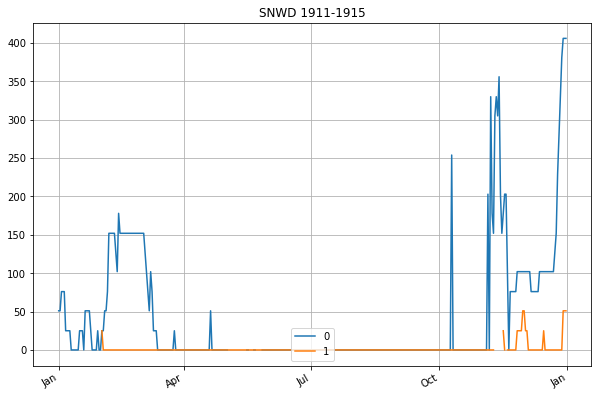

In [429]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T_S[:2,:].transpose(),fig,ax,title='SNWD 1911-1915')

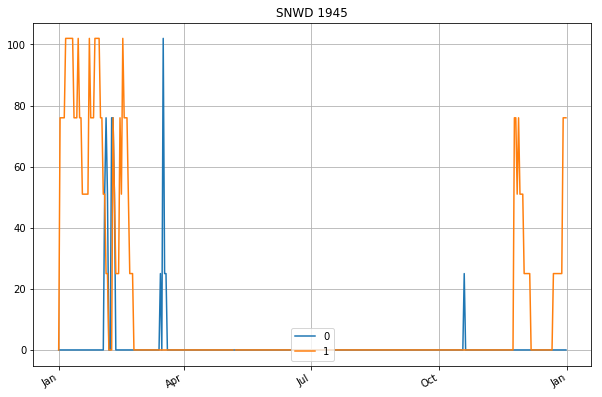

In [430]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T_S[10:12,:].transpose(),fig,ax,title='SNWD 1945')

In [431]:
data={}
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT year,vector FROM weather\n\twhere measurement='%s' "%('TMIN')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(15)
#rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
rows=df1.collect()
for key, val in rows:
    if key not in data:
        data[key]=np.nanmax(unpackArray(val,np.float16))/10.0
    else:
        if np.nanmax(unpackArray(val,np.float16))/10.0>data[key]:
            data[key]=np.nanmax(unpackArray(val,np.float16))/10.0
# if df1.year not in data:
#     print df1.year
#     data[df1.year]=unpackArray(df1.vector,np.float16)
    
# print len(rows)
# T_S=np.vstack(rows)  # scaling to make the temperature be in centingrates
# shape(T_S)

SELECT year,vector FROM weather
	where measurement='TMIN' 
2606 rows
+------+--------------------+
|  year|              vector|
+------+--------------------+
|1949.0|[00 D8 70 DA 00 7...|
|1950.0|[30 D4 80 D4 E0 D...|
|1951.0|[30 D4 00 CF 40 C...|
|1952.0|[08 D9 70 DA 98 D...|
|1953.0|[80 D1 20 D0 A0 D...|
|1954.0|[40 D6 F0 D6 50 D...|
|1955.0|[00 CF 40 D2 A0 D...|
|1956.0|[80 D1 80 CD 30 D...|
|1957.0|[E0 D4 E0 D0 A0 D...|
|1958.0|[F0 D6 40 D6 00 D...|
|1959.0|[80 CD 40 D6 08 D...|
|1960.0|[F0 D6 20 DB E0 D...|
|1961.0|[A0 D6 58 D8 B0 D...|
|1962.0|[E0 D5 90 D5 E0 D...|
|1963.0|[A0 D6 00 D3 E0 D...|
+------+--------------------+
only showing top 15 rows



In [432]:
data[1911]

21.100000000000001

In [433]:
data[2011]

23.300000000000001

In [434]:
data_new={}
for k,v in data.items():
    data_new[k]=abs(v)

In [435]:
lists = sorted(data.items()) 
x, y = zip(*lists)

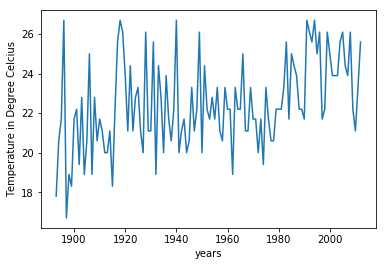

In [436]:
plt.plot(x,y)
plt.xlabel('years')
plt.ylabel('Temperature in Degree Celcius')
plt.show()

In [437]:
data={}
Query="SELECT year,vector FROM weather\n\twhere measurement='%s' sort by year"%('SNWD')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(15)
rows=df1.collect()
for key, val in rows:
    if key not in data:
        data[key]=unpackArray(val,np.float16)
#     else:
#         if np.nanmean(unpackArray(val,np.float16))/10.0>data[key]:
#             data[key]=unpackArray(val,np.float16)

SELECT year,vector FROM weather
	where measurement='SNWD' sort by year
1125 rows
+------+--------------------+
|  year|              vector|
+------+--------------------+
|1911.0|[60 52 60 52 C0 5...|
|1915.0|[00 7E 00 7E 00 7...|
|1916.0|[60 52 60 52 40 4...|
|1924.0|[00 00 00 00 00 0...|
|1925.0|[00 7E 00 7E 00 7...|
|1925.0|[F0 57 F0 57 C0 5...|
|1934.0|[00 00 00 00 00 0...|
|1941.0|[60 52 60 52 60 5...|
|1943.0|[00 00 00 00 00 0...|
|1943.0|[00 00 00 00 00 0...|
|1943.0|[00 00 00 00 00 0...|
|1944.0|[00 00 C0 54 C0 5...|
|1944.0|[00 00 60 56 60 5...|
|1945.0|[C0 54 60 52 60 5...|
|1945.0|[C0 54 60 52 40 4...|
+------+--------------------+
only showing top 15 rows



In [438]:
STAT['TMIN']['low1000']

-217.0

In [439]:
feature=unpackArray('vector',np.float16)

In [440]:
# df2=df1.groupby(['year']).agg({"year": "count", feature: "mean"})
# pdf=df2.toPandas()
# pdf.sort_values(by=['year'],inplace=True)
# pdf.head(2)

In [441]:
TT=[]

In [442]:
TT.append(data[1945])
TT.append(data[1970])
TT.append(data[1990])
TT.append(data[2011])

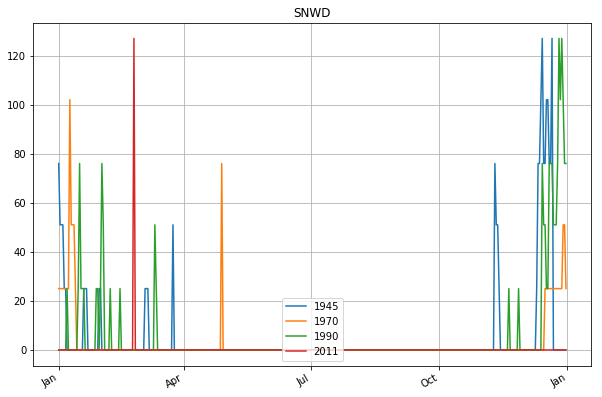

In [443]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(np.array(TT)[:4,:].transpose(),fig,ax,title='SNWD',labels=['1945','1970','1990','2011'])

In [444]:
Query="""SELECT distinct(station),vector,year from weather where station in 
(SELECT station from weather GROUP BY 1 having count(station) > 50) and measurement='%s'""" %('SNOW')
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)
rows1=df1.collect()

1691 rows
+-----------+--------------------+------+
|    station|              vector|  year|
+-----------+--------------------+------+
|USC00105980|[00 00 00 00 00 0...|1953.0|
|USC00103882|[00 00 00 00 00 0...|1989.0|
|USC00100915|[00 00 80 4A 00 0...|1972.0|
|USC00106764|[00 00 00 00 40 4...|1976.0|
|USC00107673|[00 00 70 54 00 0...|1955.0|
|USC00107040|[00 00 00 00 00 0...|2007.0|
|USC00108626|[00 00 00 00 00 0...|1915.0|
|USC00108626|[00 00 00 00 00 0...|1945.0|
|USC00101220|[00 00 00 00 00 0...|1995.0|
|USC00102071|[00 7E 00 7E 00 0...|1968.0|
+-----------+--------------------+------+
only showing top 10 rows



### Script for plotting yearly plots

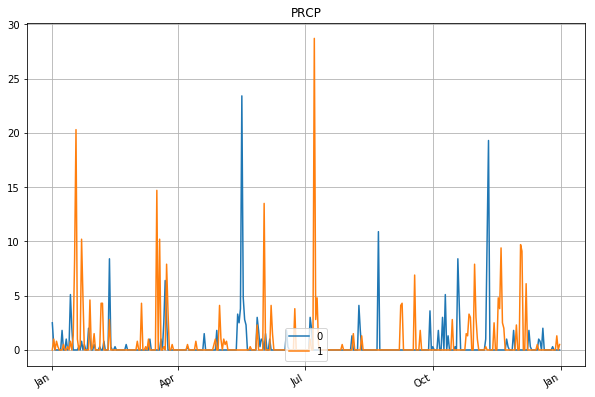

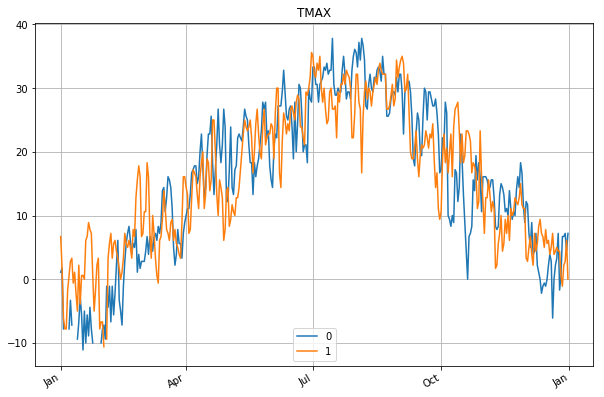

In [445]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
fig1, ax1 = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(TM[:2,:].transpose(),fig1,ax1,title='TMAX')
#title('A sample of graphs');

In the above figure we can see the variation is precipitation for two years and a particular station. We can see the peaks around different months and low in most---describe

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [446]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

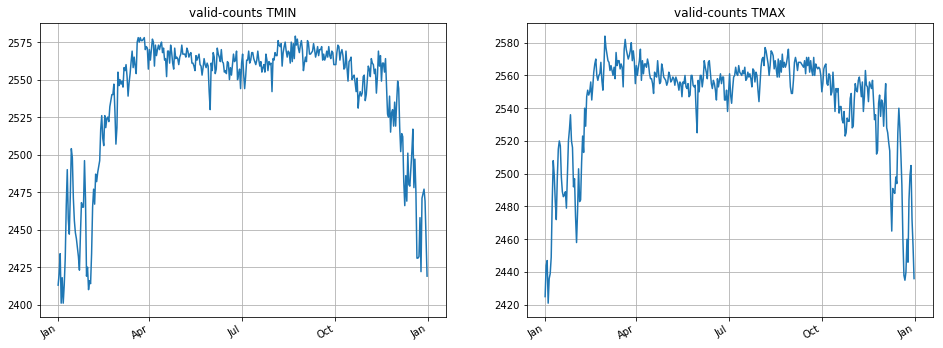

In [447]:
plot_pair(['TMIN','TMAX'],plot_valid)

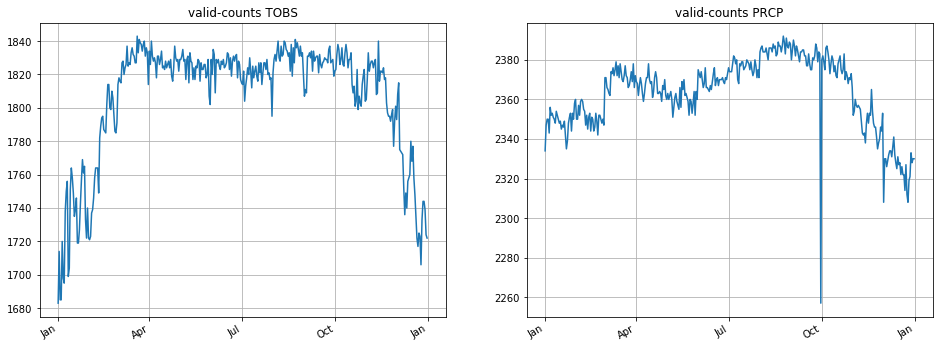

In [448]:
plot_pair(['TOBS','PRCP'],plot_valid)

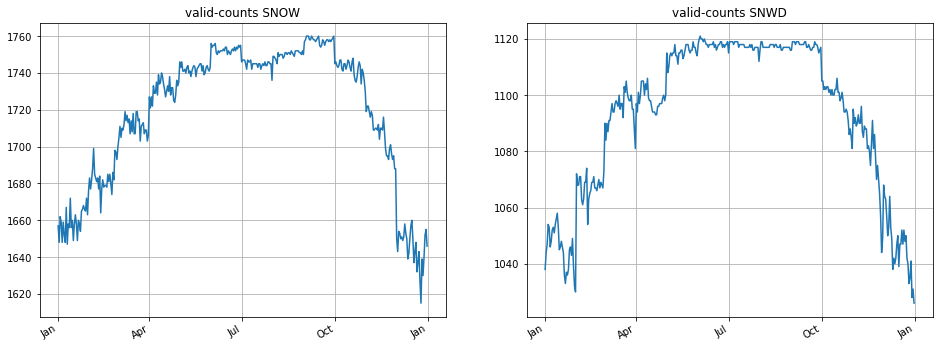

In [449]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

missing observation? NE-number of counts per day - non uniform 

### Plots of mean and std of observations

In [450]:
def plot_mean_std(m,fig,axis):
    mean=(STAT[m]['Mean']/10.0)
    std=(np.sqrt(STAT[m]['Var'])/10.0)
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

In [451]:
def plot_pair_f(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        axis.set_ylabel("Degree Fahrenheit")
        j+=1
        func(m,fig,axis)

In [452]:
def plot_mean_std_f(m,fig,axis):
    #mean=((STAT[m]['Mean']/10.0)*1.8)+32
    mean = np.array([x*1.8+32 for x in STAT[m]['Mean']/10.0])
    #std=np.sqrt(((STAT[m]['Var']/10.0)*1.8)+32)
    std = np.array([np.sqrt(x*1.8+32) for x in STAT[m]['Mean']/10.0])
#     mean=(STAT[m]['Mean']/10.0)
#     std=(np.sqrt(STAT[m]['Var'])/10.0)
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

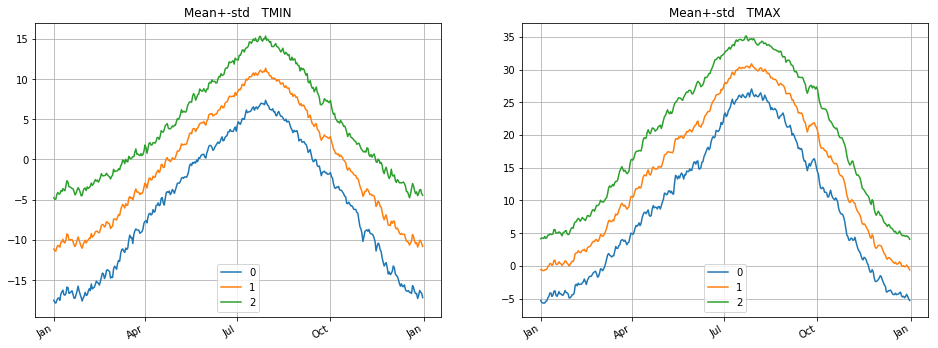

In [453]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

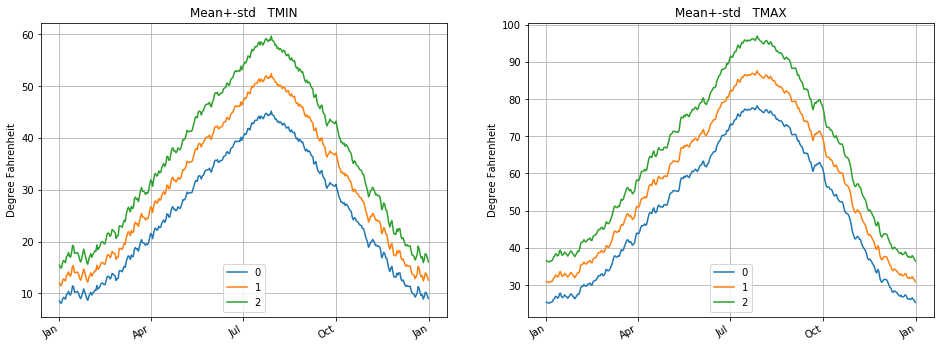

In [454]:
plot_pair_f(['TMIN','TMAX'],plot_mean_std_f)

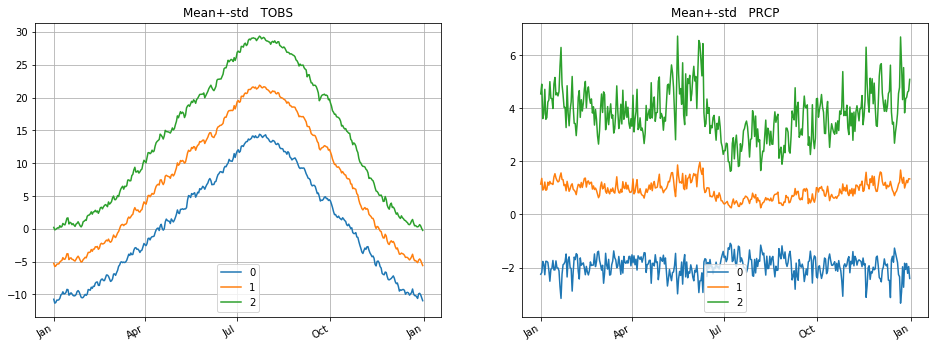

In [455]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

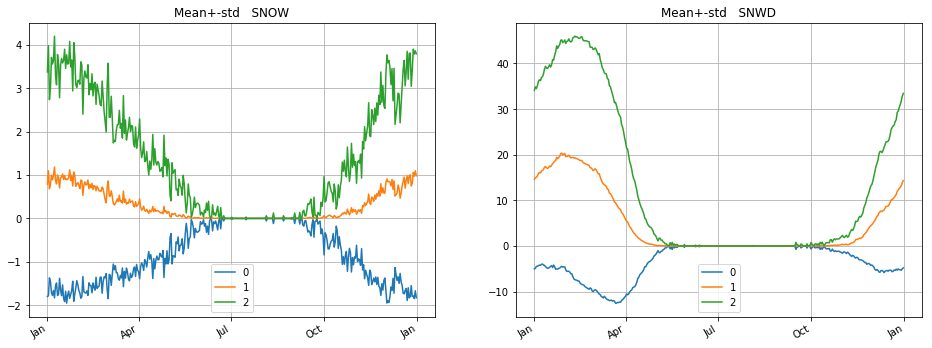

In [456]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

describe +-std for diff parameters

In [457]:
def plot_mean(m,fig,axis):
    mean=STAT[m]['Mean']
    #std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean]).transpose()
    graphs=graphs/10.0
    YP.plot(graphs,fig,axis,title='Mean  '+m)

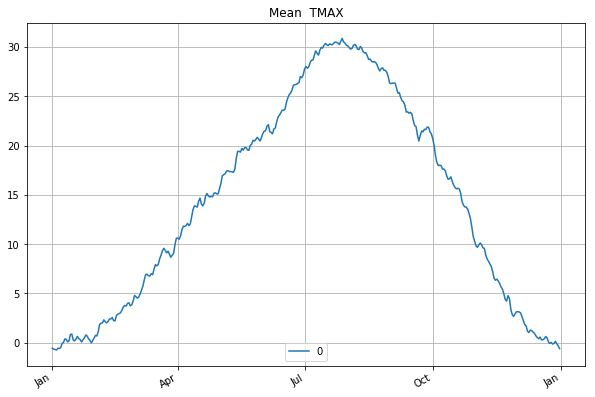

In [458]:
fig, ax = plt.subplots(figsize=(10,7));
plot_mean('TMAX',fig,ax)

### plotting top 3 eigenvectors

In [459]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

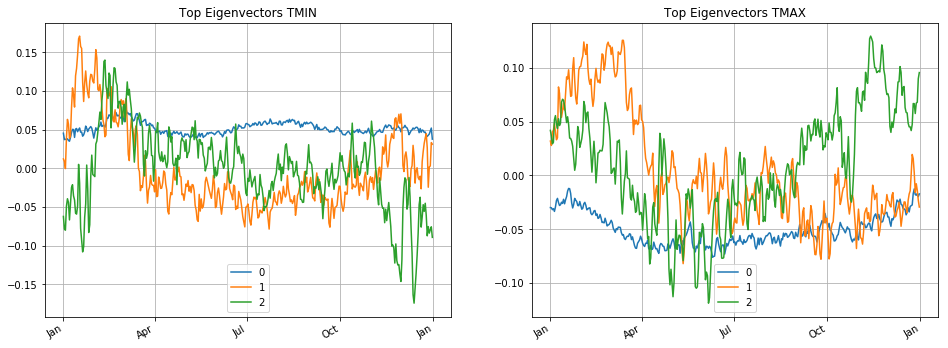

In [460]:
plot_pair(['TMIN','TMAX'],plot_eigen)

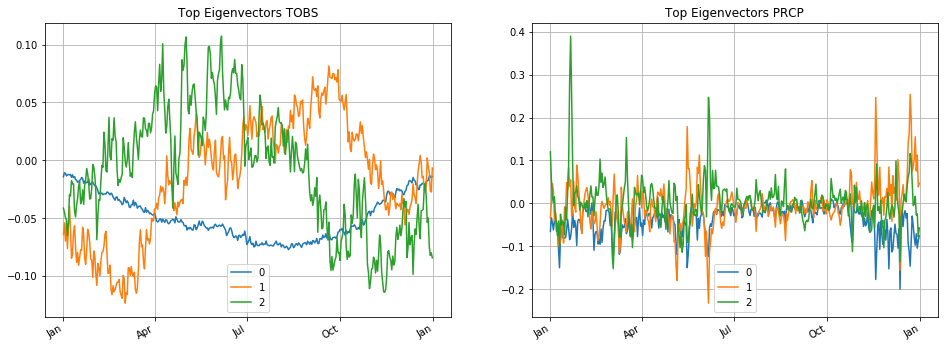

In [461]:
plot_pair(['TOBS','PRCP'],plot_eigen)

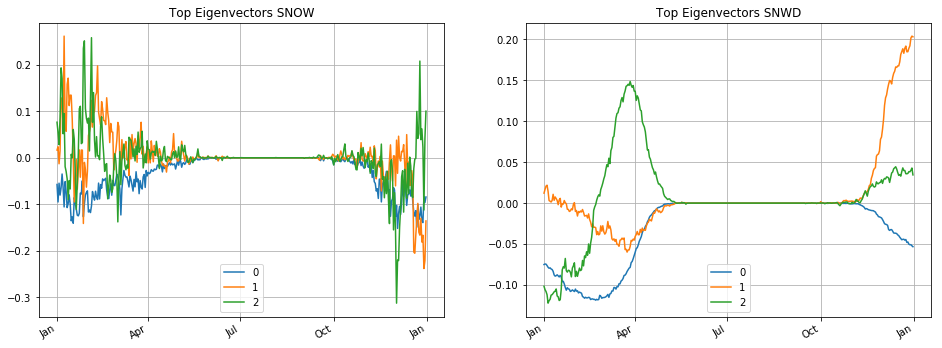

In [462]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

more variation , see what eigen vectors describe

### Script for plotting percentage of variance explained

In [463]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

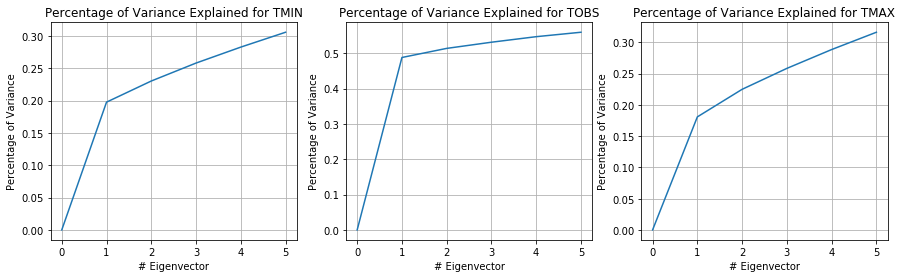

In [464]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

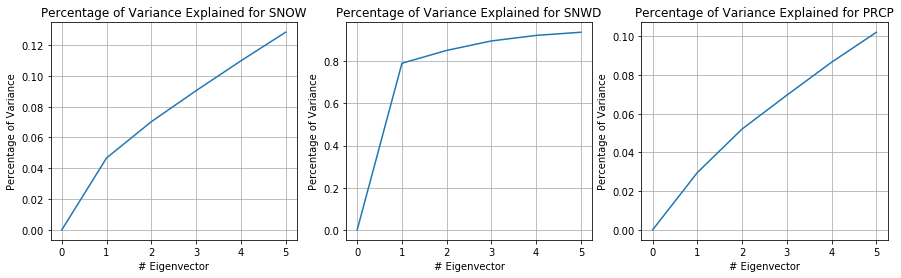

In [465]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [466]:
sc.stop()

 The eigenvalues in PCA tell you how much variance can be explained by its associated eigenvector. Therefore, the highest eigenvalue indicates the highest variance in the data was observed in the direction of its eigenvector. Accordingly, if you take all eigenvectors together, you can explain all the variance in the data sample. Instead of using the absolute value of variance explained, as indicated by the eigenvalue, you can also get relative numbers by first summing up all eigenvalues and then divide an eigenvalue  by this sum

This way you end up with a "percentage of variance" for each eigenvector.

The first eigenvector of a covariance matrix points in the
direction of maximum variance in the data. This eigenvector is
the first principal component
The second eigenvector of a covariance matrix points in the
direction, orthogonal to the first, that has the maximum
variance.

